In [1]:
from typing import Tuple, List, Dict, Union
import os
from pathlib import Path
import glob
import gc
import random
from datetime import datetime

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geojson
from patchify import patchify
import cv2


from extract_patches import create_bbox_list, get_annotated_rois, create_masks

OPENSLIDE_PATH  = r'C:/openslide/openslide-win64/bin'
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [2]:
DATA_PATH = '/mnt/d/UCL-HDS-DissertationDataset/BRACS/BRACS_WSI'
ANNOT_PATH = '/mnt/c/UCL-HDS-DissertationDataset/BRACS_WSI_Annotations'
PATCH_PATH = './data/patches'

In [3]:
slide = openslide.OpenSlide(f'{DATA_PATH}/train/Group_AT/Type_ADH/BRACS_1486.svs')

print("levels:", slide.level_count)
print("level dimensions", slide.level_dimensions)
print("level downsamples", slide.level_downsamples)

# get annotations
annotation_file = f'{ANNOT_PATH}/train/Group_AT/Type_ADH/BRACS_1486.geojson'
annotations = geojson.load(open(annotation_file))
bbox_list = create_bbox_list(annotations)

levels: 4
level dimensions ((147408, 88478), (36852, 22119), (9213, 5529), (2303, 1382))
level downsamples (1.0, 4.000045210000453, 16.001266051727256, 64.01432756493921)


In [4]:
def get_scaled_img_and_rois(slide: openslide.OpenSlide, bbox_list: List[Dict], level: int = -1) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get scaled image and rois from slide and bbox list at given downsample level, default as max downsample.
    """
    roi_bboxes = np.array(list(map(lambda x: x["coordinates"], bbox_list)))
    thumbnail_arr = np.array(slide.get_thumbnail(slide.level_dimensions[level]))
    
    slide_width, slide_height = slide.dimensions
    height, width = thumbnail_arr.shape[:2]
    width_ratio =  width / slide_width
    height_ratio = height / slide_height

    scaled_bboxes = roi_bboxes * np.array([width_ratio, height_ratio])
    return thumbnail_arr, scaled_bboxes

In [5]:
thumbnail_arr, scaled_bboxes = get_scaled_img_and_rois(slide, bbox_list, level=-1)

thumbnail_plot_arr = thumbnail_arr.copy()

for scaled_roi_bbox in scaled_bboxes:
    min_coord, max_coord = scaled_roi_bbox
    cv2.rectangle(
        thumbnail_plot_arr,
        min_coord.astype(int),
        max_coord.astype(int),
        (0, 0, 0),
        2
    )

In [6]:
def get_extract_area_coord(thumbnail_arr: np.ndarray, patch_size: int, scaled_roi_bboxes: np.ndarray) -> Tuple[Tuple[int, int], Tuple[int, int]]:
    """
    Get the coordinates of the area to extract from the thumbnail.
    """
    # get the min and max x and y coordinates among the ROIs
    min_bbox_x, min_bbox_y = scaled_roi_bboxes.reshape(-1, 2).min(axis=0).astype(int)
    max_bbox_x, max_bbox_y = scaled_roi_bboxes.reshape(-1, 2).max(axis=0).astype(int)

    # extend the min and max coordinates value to create the slide extraction area
    height, width = thumbnail_arr.shape[:2]

    # first, add 30 pixel padding to the min and max coordinates
    # check if the the points are within the bounds of thumbnail
    extract_min_x = max(0, min_bbox_x - 30)
    extract_min_y = max(0, min_bbox_y - 30)
    extract_max_x = min(width, max_bbox_x + 30)
    extract_max_y = min(height, max_bbox_y + 30)

    
    # second, extend min and max coordinates such that the width and height are divisible by 256
    extract_width = extract_max_x - extract_min_x
    extract_height = extract_max_y - extract_min_y

    add_to_left = True
    while extract_width % patch_size != 0:
        # randomly add 1 pixel to the left or right side of the image
        if add_to_left:
            extract_min_x = max(0, extract_min_x - 1)
            add_to_left = False
        else:
            extract_max_x = min(width, extract_max_x + 1)
            add_to_left = True
        extract_width = extract_max_x - extract_min_x

    add_to_top = True
    while extract_height % patch_size != 0:
        # randomly add 1 pixel to the top or bottom side of the image
        if add_to_top:
            extract_min_y = max(0, extract_min_y - 1)
            add_to_top = False
        else:
            extract_max_y = min(height, extract_max_y + 1)
            add_to_top = True
        extract_height = extract_max_y - extract_min_y

    
    return (extract_min_x, extract_min_y), (extract_max_x, extract_max_y)

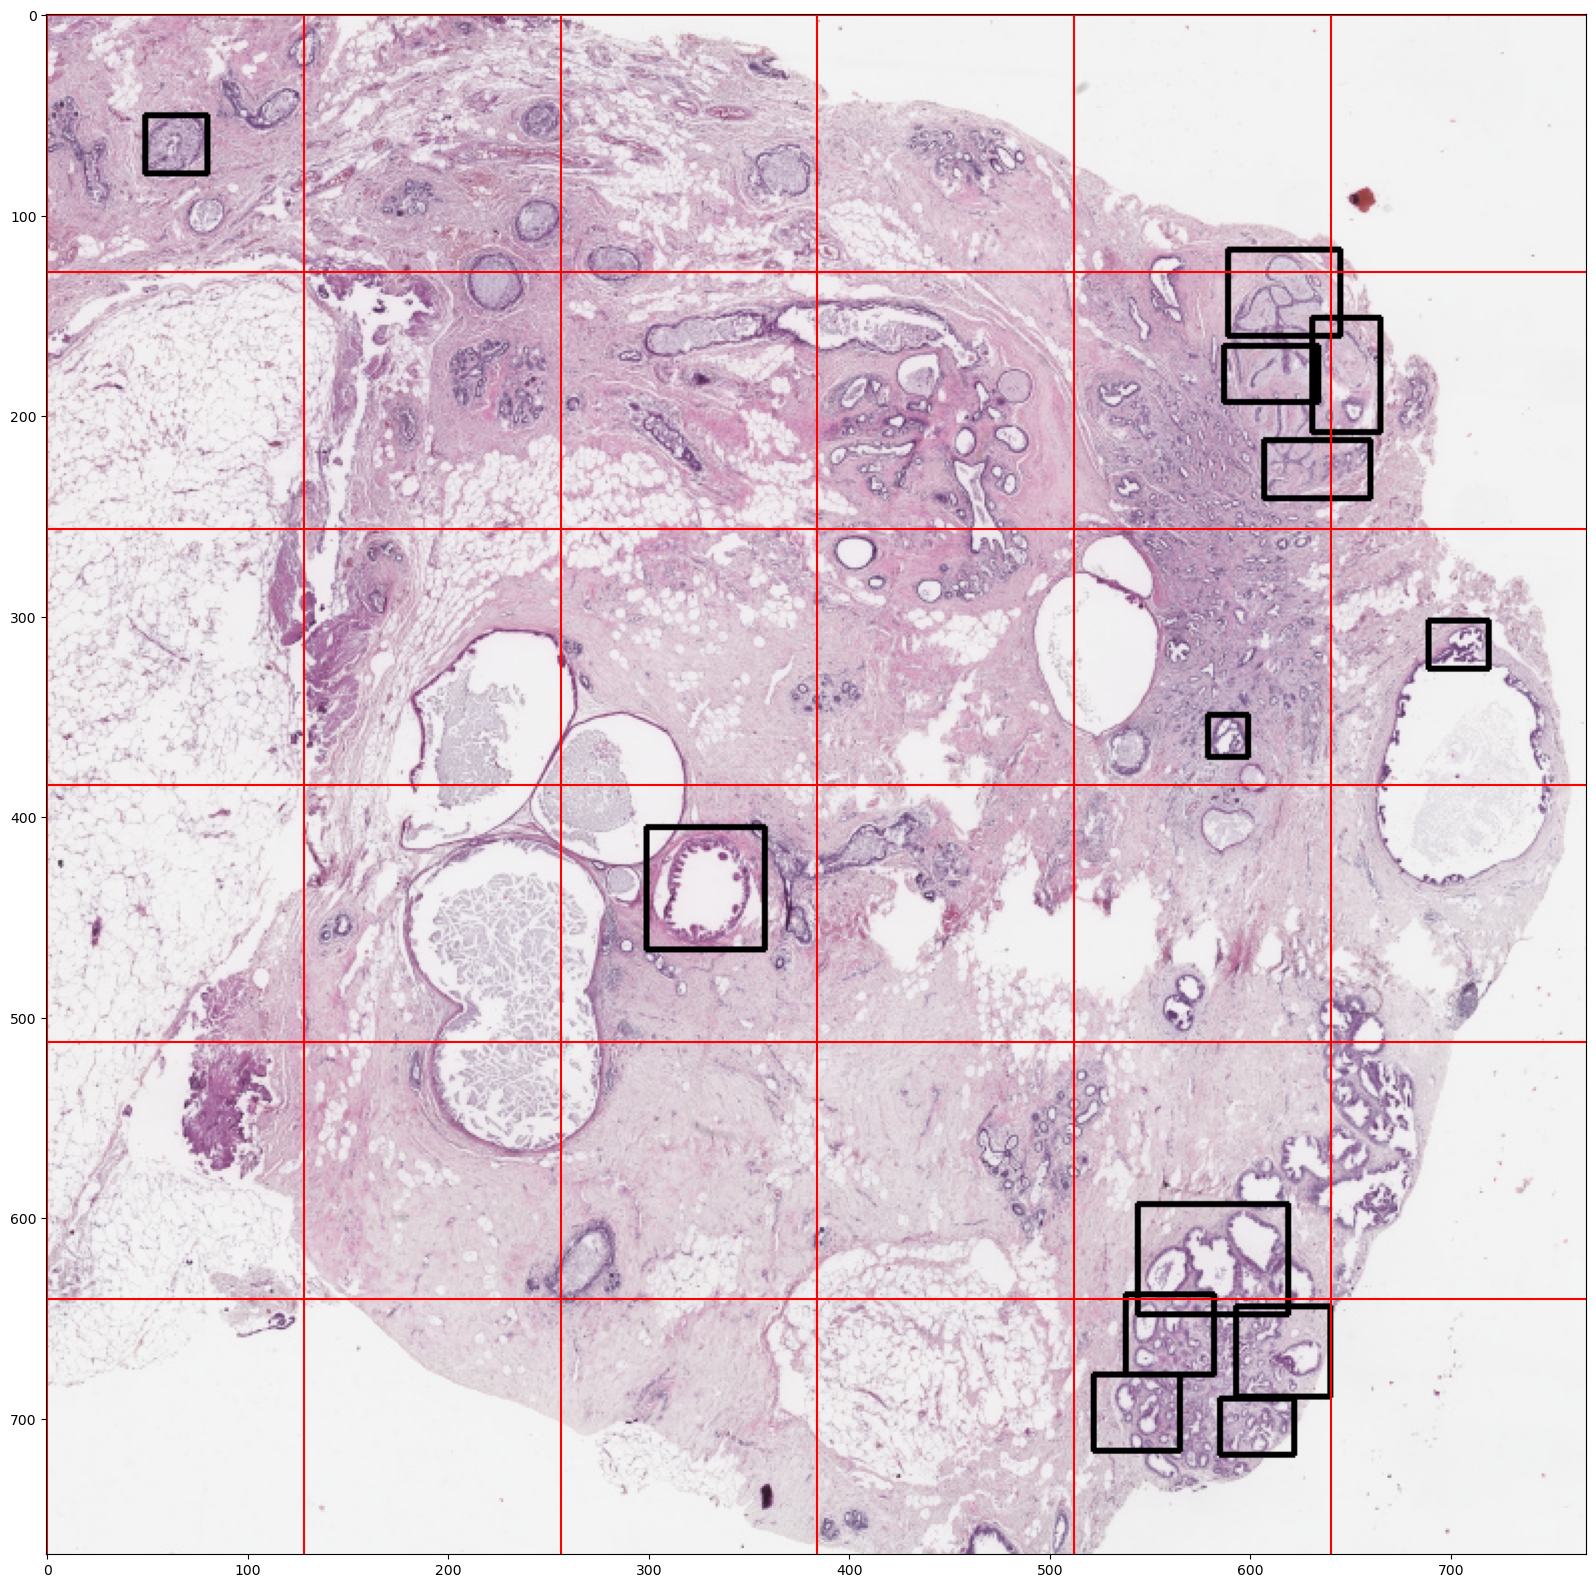

In [7]:
PATCH_SIZE = 256
STEP_SIZE = 128

(extract_min_x, extract_min_y), (extract_max_x, extract_max_y) = get_extract_area_coord(thumbnail_arr, PATCH_SIZE, scaled_bboxes)

fig = plt.figure(figsize=(20, 20))
plt.imshow(thumbnail_plot_arr[extract_min_y:extract_max_y, extract_min_x:extract_max_x, :])
# draw lines at 256 pixel intervals vertically and horizontally to indictate the 256x256 patches
for i in range(0, extract_max_x-extract_min_x, STEP_SIZE):
    plt.axvline(i, color='r')
for i in range(0, extract_max_y-extract_min_y, STEP_SIZE):
    plt.axhline(i, color='r')

plt.show()

In [8]:
def patchify_area_rois(
        thumbnail_arr: np.ndarray,
        extract_area_coord: Tuple[Tuple[int, int], Tuple[int, int]],
        patch_size: int, step_size: int, scaled_bboxes: np.ndarray
    ):
    """
    Patchify the slide image and retrieve the relative coordinates of the bboxes in the patchified images
    """
    (extract_min_x, extract_min_y), (extract_max_x, extract_max_y) = extract_area_coord
    extract_area_arr = thumbnail_arr[extract_min_y:extract_max_y, extract_min_x:extract_max_x, :]

    # patchify the slide image, each patch is 512x512, step is 256
    slide_patches = patchify(extract_area_arr, (patch_size, patch_size, 3), step=step_size)

    # create a list of dict including patches and the corresponding list of roi in relative coordinates
    area_and_rois = []
    for i in range(slide_patches.shape[0]):
            patch_annots_row = []
            for j in range(slide_patches.shape[1]):
                patch_annots_row.append({
                        'patch': slide_patches[i, j, 0],
                        'roi_bboxes': []
                })
            area_and_rois.append(patch_annots_row)
            
    assert (area_and_rois[0][0]['patch'] == slide_patches[0, 0, ::]).all() 

    # retrieve relative coordinates of the bboxes in the patchified images
    for scaled_roi_bbox in scaled_bboxes:
        # get the bbox coordinates
        (min_x, min_y), (max_x, max_y) = scaled_roi_bbox
        
        # get the step index of the bbox
        min_x_step_idx = int((min_x - extract_min_x) // step_size)
        min_y_step_idx = int((min_y - extract_min_y) // step_size)
        max_x_step_idx = int((max_x - extract_min_x) // step_size)
        max_y_step_idx = int((max_y - extract_min_y) // step_size)

        # compile a list of patches that the bbox is in, indicated by the patch indices
        patch_list: List[Tuple[int]] = []
        for x in range( # the range is computed by the step index of the bbox
            max(0, min_x_step_idx - patch_size//step_size + 1), # min patch x
            min(slide_patches.shape[1], max_x_step_idx + 1) # max patch x
        ):
            for y in range( # the range is computed by the step index of the bbox
                max(0, min_y_step_idx - patch_size//step_size + 1), # min patch y
                min(slide_patches.shape[0], max_y_step_idx + 1) # max patch y
            ):
                patch_list.append((y, x))

        for patch_idx in patch_list:
            # get the relative coordinates of the bbox in the patch
            patch_min_x = max(0, min_x - extract_min_x - patch_idx[1] * STEP_SIZE)
            patch_min_y = max(0, min_y - extract_min_y - patch_idx[0] * STEP_SIZE)
            patch_max_x = min(PATCH_SIZE, max_x - extract_min_x - patch_idx[1] * STEP_SIZE)
            patch_max_y = min(PATCH_SIZE, max_y - extract_min_y - patch_idx[0] * STEP_SIZE)
            # print(patch_min_x, patch_min_y, patch_max_x, patch_max_y)
            
            area_and_rois[patch_idx[0]][patch_idx[1]]["roi_bboxes"].append(
                np.array([(patch_min_x, patch_min_y), (patch_max_x, patch_max_y)], dtype=int)
            )

    return area_and_rois

In [9]:
# get a copy of the patch
patch_annots = patchify_area_rois(
    thumbnail_arr,
    get_extract_area_coord(thumbnail_arr, PATCH_SIZE, scaled_bboxes),
    PATCH_SIZE, STEP_SIZE, scaled_bboxes
)

In [10]:
def save_obj_detect_patch_and_roi(area_and_rois: List, save_path: str = '.', verbose: bool = False):
    """
    Save the area and rois to a file
    """
    for row_idx, row in enumerate(area_and_rois):
        for col_idx, patch_rois in enumerate(row):
            patch: np.ndarray = patch_rois["patch"]
            rois: List[np.ndarray] = patch_rois["roi_bboxes"]

            # Save the patch
            os.makedirs(f"{save_path}/patch", exist_ok=True)
            Image.fromarray(patch).save(f"{save_path}/patch/{row_idx}_{col_idx}.png")

            # Save the rois
            os.makedirs(f"{save_path}/roi", exist_ok=True)
            np.save(f"{save_path}/roi/{row_idx}_{col_idx}.npy", rois)

    if verbose:
        print(f"Saved patches image and bbox json to {save_path}")

In [11]:
save_obj_detect_patch_and_roi(patch_annots)

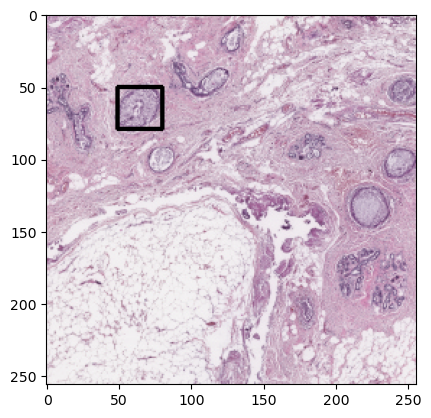

In [12]:
sample_slide_patch_plot_arr = cv2.imread('./patch/0_0.png')
sample_slide_patch_plot_arr = cv2.cvtColor(sample_slide_patch_plot_arr, cv2.COLOR_BGR2RGB)

# draw rectangle on the patch copy
for annot in np.load('./roi/0_0.npy'):
    cv2.rectangle(
        sample_slide_patch_plot_arr,
        annot[0],
        annot[1],
        (0, 0, 0),
        2
    )

plt.imshow(sample_slide_patch_plot_arr)

In [13]:
THUMB_PATH = './data/thumbnail_patches/'

In [14]:
PATCH_SIZE = 256
STEP_SIZE = 128


if __name__ == '__main__':

    failed_file_path = Path(f'./logs/failed_slide_files-{datetime.now().strftime("%Y%m%d-%H%M%S")}.txt')

    # get all annotations
    train_set = glob.glob(f'{ANNOT_PATH}/train/**/*.geojson', recursive=True)
    val_set = glob.glob(f'{ANNOT_PATH}/val/**/*.geojson', recursive=True)
    test_set = glob.glob(f'{ANNOT_PATH}/test/**/*.geojson', recursive=True)

    for train_annot_path in train_set:
        file_id = train_annot_path.split('/')[-1].split('.')[0]
        # create if not exists
        if not f'{THUMB_PATH}/train/{file_id}' in glob.glob(f'{THUMB_PATH}/train/{file_id}'):
            print('processing:', file_id)
            wsi_file_paths = glob.glob(f'{DATA_PATH}/train/**/{file_id}.svs', recursive=True)

            if len(wsi_file_paths) != 0:
                try:
                    slide = openslide.OpenSlide(wsi_file_paths[0])
                    annotations = geojson.load(open(train_annot_path))
                    bbox_list = create_bbox_list(annotations)

                    thumbnail_arr, scaled_bboxes = get_scaled_img_and_rois(slide, bbox_list, level=-1)

                    (extract_min_x, extract_min_y), (extract_max_x, extract_max_y) = get_extract_area_coord(thumbnail_arr, PATCH_SIZE, scaled_bboxes)

                    Path(f'{THUMB_PATH}/train').mkdir(parents=True, exist_ok=True)
                    patch_annots = patchify_area_rois(
                        thumbnail_arr,
                        get_extract_area_coord(thumbnail_arr, PATCH_SIZE, scaled_bboxes),
                        PATCH_SIZE, STEP_SIZE, scaled_bboxes
                    )
                    save_obj_detect_patch_and_roi(patch_annots, save_path=f'{THUMB_PATH}/train/{file_id}')
                except:
                    failed_file_path.parent.mkdir(parents=True, exist_ok=True)
                    with open(failed_file_path, 'a+') as f:
                        f.write(f'{file_id}\n')
                finally:
                    slide.close()
            gc.collect()
        else:
            print(f'{THUMB_PATH}/train/{file_id} already exists')

    for val_annot_path in val_set:
        file_id = val_annot_path.split('/')[-1].split('.')[0]
        print('processing:', file_id)
        wsi_file_paths = glob.glob(f'{DATA_PATH}/val/**/{file_id}.svs', recursive=True)

        if not f'{THUMB_PATH}/val/{file_id}' in glob.glob(f'{THUMB_PATH}/val/{file_id}'):
            if len(wsi_file_paths) != 0:
                try:
                    slide = openslide.OpenSlide(wsi_file_paths[0])
                    annotations = geojson.load(open(val_annot_path))
                    bbox_list = create_bbox_list(annotations)

                    thumbnail_arr, scaled_bboxes = get_scaled_img_and_rois(slide, bbox_list, level=-1)

                    (extract_min_x, extract_min_y), (extract_max_x, extract_max_y) = get_extract_area_coord(thumbnail_arr, PATCH_SIZE, scaled_bboxes)

                    Path(f'{THUMB_PATH}/val').mkdir(parents=True, exist_ok=True)
                    patch_annots = patchify_area_rois(
                        thumbnail_arr,
                        get_extract_area_coord(thumbnail_arr, PATCH_SIZE, scaled_bboxes),
                        PATCH_SIZE, STEP_SIZE, scaled_bboxes
                    )
                    save_obj_detect_patch_and_roi(patch_annots, save_path=f'{THUMB_PATH}/val/{file_id}')
                except:
                    failed_file_path.parent.mkdir(parents=True, exist_ok=True)
                    with open(failed_file_path, 'a+') as f:
                        f.write(f'{file_id}\n')
                finally:
                    slide.close()
            gc.collect()
        else:
            print(f'{THUMB_PATH}/val/{file_id} already exists')

processing: BRACS_1003728
processing: BRACS_1486
processing: BRACS_1494
processing: BRACS_1499
processing: BRACS_1616
processing: BRACS_1622
processing: BRACS_1794
processing: BRACS_1795
processing: BRACS_1808
processing: BRACS_1860
processing: BRACS_1861
processing: BRACS_1863
processing: BRACS_1877
processing: BRACS_1882
processing: BRACS_1899
processing: BRACS_1911
processing: BRACS_1912
processing: BRACS_1913
processing: BRACS_1915
processing: BRACS_1922
processing: BRACS_1925
processing: BRACS_1932
processing: BRACS_1933
processing: BRACS_1934
processing: BRACS_1003693
processing: BRACS_1239
processing: BRACS_1250
processing: BRACS_1257
processing: BRACS_1319
processing: BRACS_1506
processing: BRACS_1510
processing: BRACS_1773
processing: BRACS_1774
processing: BRACS_1775
processing: BRACS_1777
processing: BRACS_1778
processing: BRACS_1788
processing: BRACS_1815
processing: BRACS_1838
processing: BRACS_1857
processing: BRACS_1858
processing: BRACS_1865
processing: BRACS_1871
proce